# 서울 부동산 시장 분석 및 투자 전략 수립

## 과제 3: 부동산 거래량과 가격의 선행지표 관계 분석
부동산 거래량 변화가 가격 변동에 미치는 영향을 시차 분석을 통해 파악하고, 시장 전환점을 예측할 수 있는 지표를 개발

- 월별 부동산 거래량 변화 확인
- 시장 전환점 예측(변곡점, 극대값, 극소값 등) 지표 개발

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import display

warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

df_sales = pd.read_csv('./data/sales_clean.csv')
df_sales['계약월'] = pd.to_datetime(df_sales['계약월'], format='%Y-%m-%d')

In [10]:
# 월별 계산
from da_utils.calc_monthly_annual import calc_monthly_annual
monthly_stats, _ = calc_monthly_annual(df_sales)

# 월별 거래량, 평단가 변화율 계산
monthly_stats['월별거래량변화율'] = monthly_stats['월별거래건수'].pct_change()
monthly_stats['월평균거래금액변화율'] = monthly_stats['월평균거래금액'].pct_change()
monthly_stats['월평균평단가변화율'] = monthly_stats['월평균평단가'].pct_change()

display(monthly_stats)

,계약월,월별거래건수,월평균거래금액,중위가격,월평균평단가,월별수익률,이동평균,이동표준편차,월별거래량변화율,월평균거래금액변화율,월평균평단가변화율
0,2020-01-01,6440,6.605127e+08,5.900000e+08,2.993413e+07,NaN,6.605127e+08,NaN,NaN,NaN,NaN
1,2020-02-01,8285,6.878718e+08,5.975821e+08,3.097167e+07,0.040586,6.741922e+08,1.934587e+07,0.286491,0.041421,0.034661
2,2020-03-01,4340,6.714325e+08,5.658480e+08,3.039139e+07,-0.024189,6.732723e+08,1.377207e+07,-0.476162,-0.023899,-0.018736
3,2020-04-01,3029,7.198466e+08,5.753918e+08,3.163618e+07,0.069625,6.849159e+08,2.585998e+07,-0.302074,0.072106,0.040959
4,2020-05-01,5486,8.266851e+08,6.592815e+08,3.490379e+07,0.138386,7.132698e+08,6.724029e+07,0.811159,0.148418,0.103287
...,...,...,...,...,...,...,...,...,...,...,...
61,2025-02-01,6242,1.281698e+09,1.026078e+09,5.275818e+07,0.148188,1.088320e+09,7.420877e+07,0.905372,0.159731,0.121655
62,2025-03-01,9565,1.225747e+09,1.007011e+09,5.085448e+07,-0.044635,1.109304e+09,7.452522e+07,0.532361,-0.043654,-0.036084
63,2025-04-01,4946,9.710168e+08,7.998256e+08,4.189111e+07,-0.232962,1.106742e+09,7.895551e+07,-0.482906,-0.207816,-0.176255
64,2025-05-01,7055,1.047272e+09,8.952748e+08,4.501218e+07,0.075600,1.105997e+09,7.951590e+07,0.426405,0.078531,0.074504


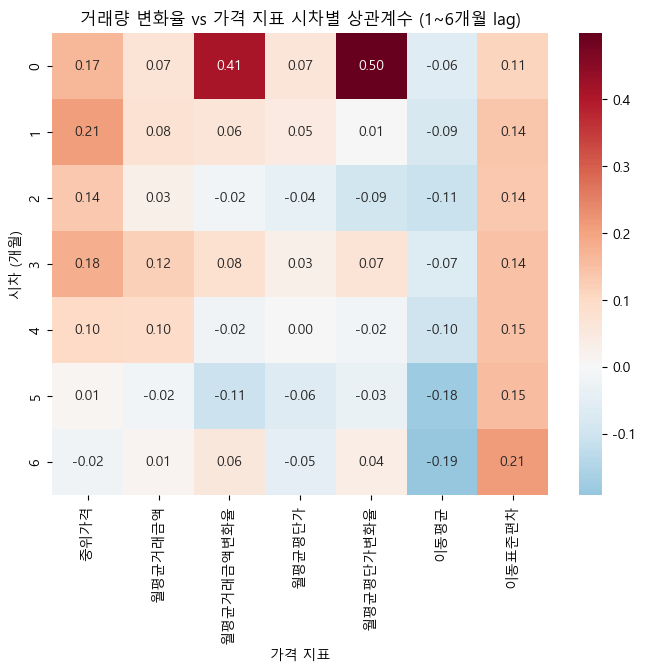

In [14]:
# 분석할 컬럼
price_cols = ['중위가격', '월평균거래금액', '월평균거래금액변화율', '월평균평단가', '월평균평단가변화율', '이동평균', '이동표준편차']
volume_change_col = '월별거래량변화율'

# 결과 저장용 데이터프레임
lag_range = range(0, 7)  # 0~6개월 시차
corr_df = pd.DataFrame(index=lag_range, columns=price_cols)

# 시차별 상관계수 계산
for lag in lag_range:
    for col in price_cols:
        corr = monthly_stats[volume_change_col].shift(lag).corr(monthly_stats[col])
        corr_df.loc[lag, col] = corr

# 결과 확인
corr_df = corr_df.astype(float) 

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True, cmap='RdBu_r', center=0, fmt=".2f")
plt.title('거래량 변화율 vs 가격 지표 시차별 상관계수 (1~6개월 lag)')
plt.xlabel('가격 지표')
plt.ylabel('시차 (개월)')
plt.show()


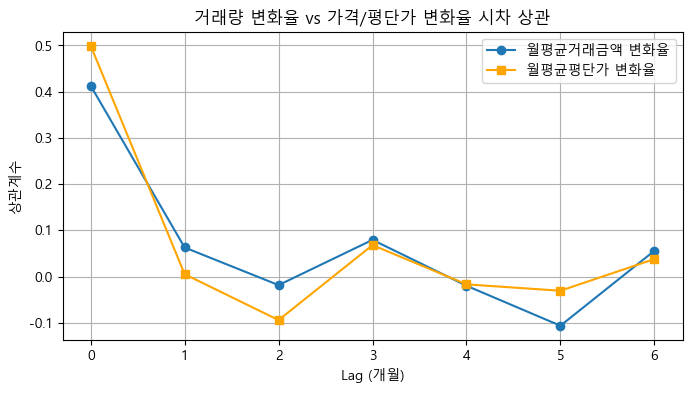

In [16]:
max_lag = 6
lag_corr_volume_price = {}
lag_corr_volume_avg_price = {}

for lag in range(0, max_lag+1):
    # 거래량 → 월평균거래금액 변화율
    lag_corr_volume_price[lag] = monthly_stats['월별거래량변화율'].shift(lag).corr(monthly_stats['월평균거래금액변화율'])
    # 거래량 → 월평균평단가 변화율
    lag_corr_volume_avg_price[lag] = monthly_stats['월별거래량변화율'].shift(lag).corr(monthly_stats['월평균평단가변화율'])

# DataFrame 생성
lag_corr_df_price = pd.DataFrame(list(lag_corr_volume_price.items()), columns=['Lag(개월)', '상관계수'])
lag_corr_df_avg_price = pd.DataFrame(list(lag_corr_volume_avg_price.items()), columns=['Lag(개월)', '상관계수'])

# 시각화
plt.figure(figsize=(8,4))
plt.plot(lag_corr_df_price['Lag(개월)'], lag_corr_df_price['상관계수'], marker='o', label='월평균거래금액 변화율')
plt.plot(lag_corr_df_avg_price['Lag(개월)'], lag_corr_df_avg_price['상관계수'], marker='s', label='월평균평단가 변화율', color='orange')
plt.title('거래량 변화율 vs 가격/평단가 변화율 시차 상관')
plt.xlabel('Lag (개월)')
plt.ylabel('상관계수')
plt.grid(True)
plt.legend()
plt.show()

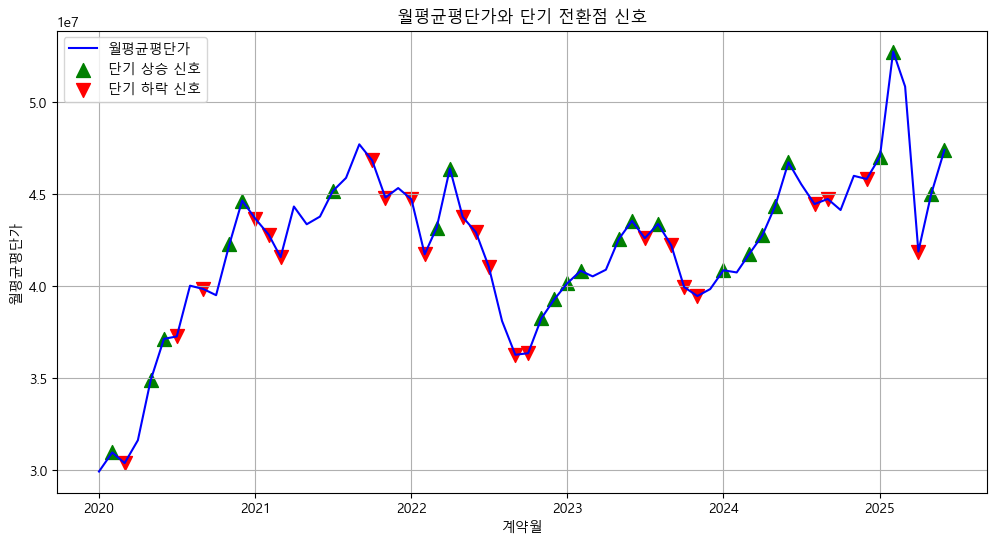

In [46]:
# 비교 대상
search = '월평균평단가'

# 임계치 계산
threshold = 0.5
vol_thresh_up = monthly_stats['월별거래량변화율'].quantile(1- threshold)
vol_thresh_dn = monthly_stats['월별거래량변화율'].quantile(threshold)
price_thresh_up = monthly_stats[f'{search}변화율'].quantile(1- threshold)
price_thresh_dn = monthly_stats[f'{search}변화율'].quantile(threshold)


# 신호 생성
def signal(row):
    if (row['월별거래량변화율'] > vol_thresh_up) and (row[f'{search}변화율'] > price_thresh_up):
        return 1  # 단기 상승 신호
    elif (row['월별거래량변화율'] < vol_thresh_dn) and (row[f'{search}변화율'] < price_thresh_dn):
        return -1  # 단기 하락 신호
    else:
        return 0  # 신호 없음

monthly_stats['단기전환점신호'] = monthly_stats.apply(signal, axis=1)

plt.figure(figsize=(12,6))
plt.plot(monthly_stats['계약월'], monthly_stats[search], label=search, color='blue')

# 상승 신호 표시
plt.scatter(monthly_stats.loc[monthly_stats['단기전환점신호']==1, '계약월'],
            monthly_stats.loc[monthly_stats['단기전환점신호']==1, search],
            color='green', marker='^', label='단기 상승 신호', s=100)

# 하락 신호 표시
plt.scatter(monthly_stats.loc[monthly_stats['단기전환점신호']==-1, '계약월'],
            monthly_stats.loc[monthly_stats['단기전환점신호']==-1, search],
            color='red', marker='v', label='단기 하락 신호', s=100)

plt.title(f'{search}와 단기 전환점 신호')
plt.xlabel('계약월')
plt.ylabel(search)
plt.legend()
plt.grid(True)
plt.show()


In [47]:
# 다음 달 가격 변화율 계산
monthly_stats['다음달변화'] = monthly_stats[search].shift(-1) - monthly_stats[search]

# 실제 상승/하락 라벨
monthly_stats['실제변곡점'] = monthly_stats['다음달변화'].apply(lambda x: 1 if x>0 else (-1 if x<0 else 0))

from sklearn.metrics import precision_score, recall_score, f1_score

# 신호와 실제 변곡점 비교
y_true = monthly_stats['실제변곡점']
y_pred = monthly_stats['단기전환점신호']

# 상승 신호 평가
precision_up = precision_score(y_true, y_pred, labels=[1], average='macro')
recall_up = recall_score(y_true, y_pred, labels=[1], average='macro')
f1_up = f1_score(y_true, y_pred, labels=[1], average='macro')

# 하락 신호 평가
precision_dn = precision_score(y_true, y_pred, labels=[-1], average='macro')
recall_dn = recall_score(y_true, y_pred, labels=[-1], average='macro')
f1_dn = f1_score(y_true, y_pred, labels=[-1], average='macro')

# 결과 출력
performance = pd.DataFrame({
    'threshold':threshold,
    'precision_up':[precision_up],
    'recall_up':[recall_up],
    'f1_up':[f1_up],
    'precision_dn':[precision_dn],
    'recall_dn':[recall_dn],
    'f1_dn':[f1_dn]
})

performance

,threshold,precision_up,recall_up,f1_up,precision_dn,recall_dn,f1_dn
0,0.5,0.583333,0.378378,0.459016,0.478261,0.392857,0.431373
